In [12]:
from datetime import datetime
import warnings
import os

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import RocCurveDisplay, roc_curve
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

from get_model_training_data_05 import get_features_and_data, BetaRegression
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

set_config(transform_output="pandas")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [2]:
(df, train_df, test_df, features, next_month) = get_features_and_data()

training examples = 2256, testing examples = 251


In [6]:
df["prob_of_release"] = df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)
train_df["prob_of_release"] = train_df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)
test_df["prob_of_release"] = test_df["prob_of_release"].apply(lambda x : 0.9999 if x == 1 else x)

## Model-Building and Evaluation

In [4]:
def train_model(train_df):
    ct = ColumnTransformer(remainder="passthrough",
                           transformers=[
                               ("ss", StandardScaler(), ["days_since_previous_release", "month_holidays"])])

    pipeline = Pipeline(
        [("ct", ct), ("br", BetaRegression())])
    
    pipeline.fit(train_df[features], train_df["prob_of_release"])
    
    return pipeline

In [7]:
model = train_model(train_df)

In [9]:
sorted(zip(model.feature_names_in_, model["br"].coef_), key=lambda x : x[1], reverse=True)

[('days_since_previous_release', 0.7163491920813271),
 ('WD_Thursday', 0.36542293318589114),
 ('WD_Friday', 0.3076220664837189),
 ('WD_Wednesday', 0.2973580368288179),
 ('M_Sep', 0.26315564775353417),
 ('M_Apr', 0.16333444051230533),
 ('M_Jun', 0.15149493634178318),
 ('M_Jul', 0.13017846187786242),
 ('month_holidays', 0.12425250156758996),
 ('M_Jan', 0.1018742281932586),
 ('M_Oct', 0.09704071627575701),
 ('M_Aug', 0.08817356163634198),
 ('WD_Saturday', 0.06515294574543089),
 ('M_Dec', 0.0500169180589022),
 ('M_May', 0.014947386547613347),
 ('WD_Tuesday', -0.01394944261141156),
 ('M_Nov', -0.01681291290477296),
 ('M_Mar', -0.12506230978484542),
 ('WD_Sunday', -0.13683531632311383),
 ('WD_Monday', -0.2673938402880635),
 ('M_Feb', -0.30096369148646596),
 ('previous_release_post', -0.8654900941929247)]

In [10]:
test_df["predicted_prob"] = model.predict(test_df[features])

In [11]:
mape(test_df["prob_of_release"], test_df["predicted_prob"])

0.43939716551351177

In [13]:
wape(test_df["prob_of_release"], test_df["predicted_prob"])

0.2702370007416064

In [14]:
test_df["residuals"] = test_df["predicted_prob"] - test_df["prob_of_release"]
# sns.scatterplot(data=test_df, x="predicted_prob", y="residuals", s=75)

In [15]:
test_df[["index", "prob_of_release", "predicted_prob", "residuals"]].sort_values(by=["residuals"])

,index,prob_of_release,predicted_prob,residuals
2432,2023-10-16,0.999900,0.494241,-0.505659
2507,2023-12-30,0.999900,0.511157,-0.488743
2373,2023-08-18,0.999900,0.554298,-0.445602
2334,2023-07-10,0.999900,0.556742,-0.443158
2336,2023-07-12,0.999900,0.588315,-0.411585
...,...,...,...,...
2339,2023-07-15,0.214286,0.584833,0.370548
2449,2023-11-02,0.250000,0.620694,0.370694
2415,2023-09-29,0.250000,0.622517,0.372517
2407,2023-09-21,0.250000,0.636000,0.386000


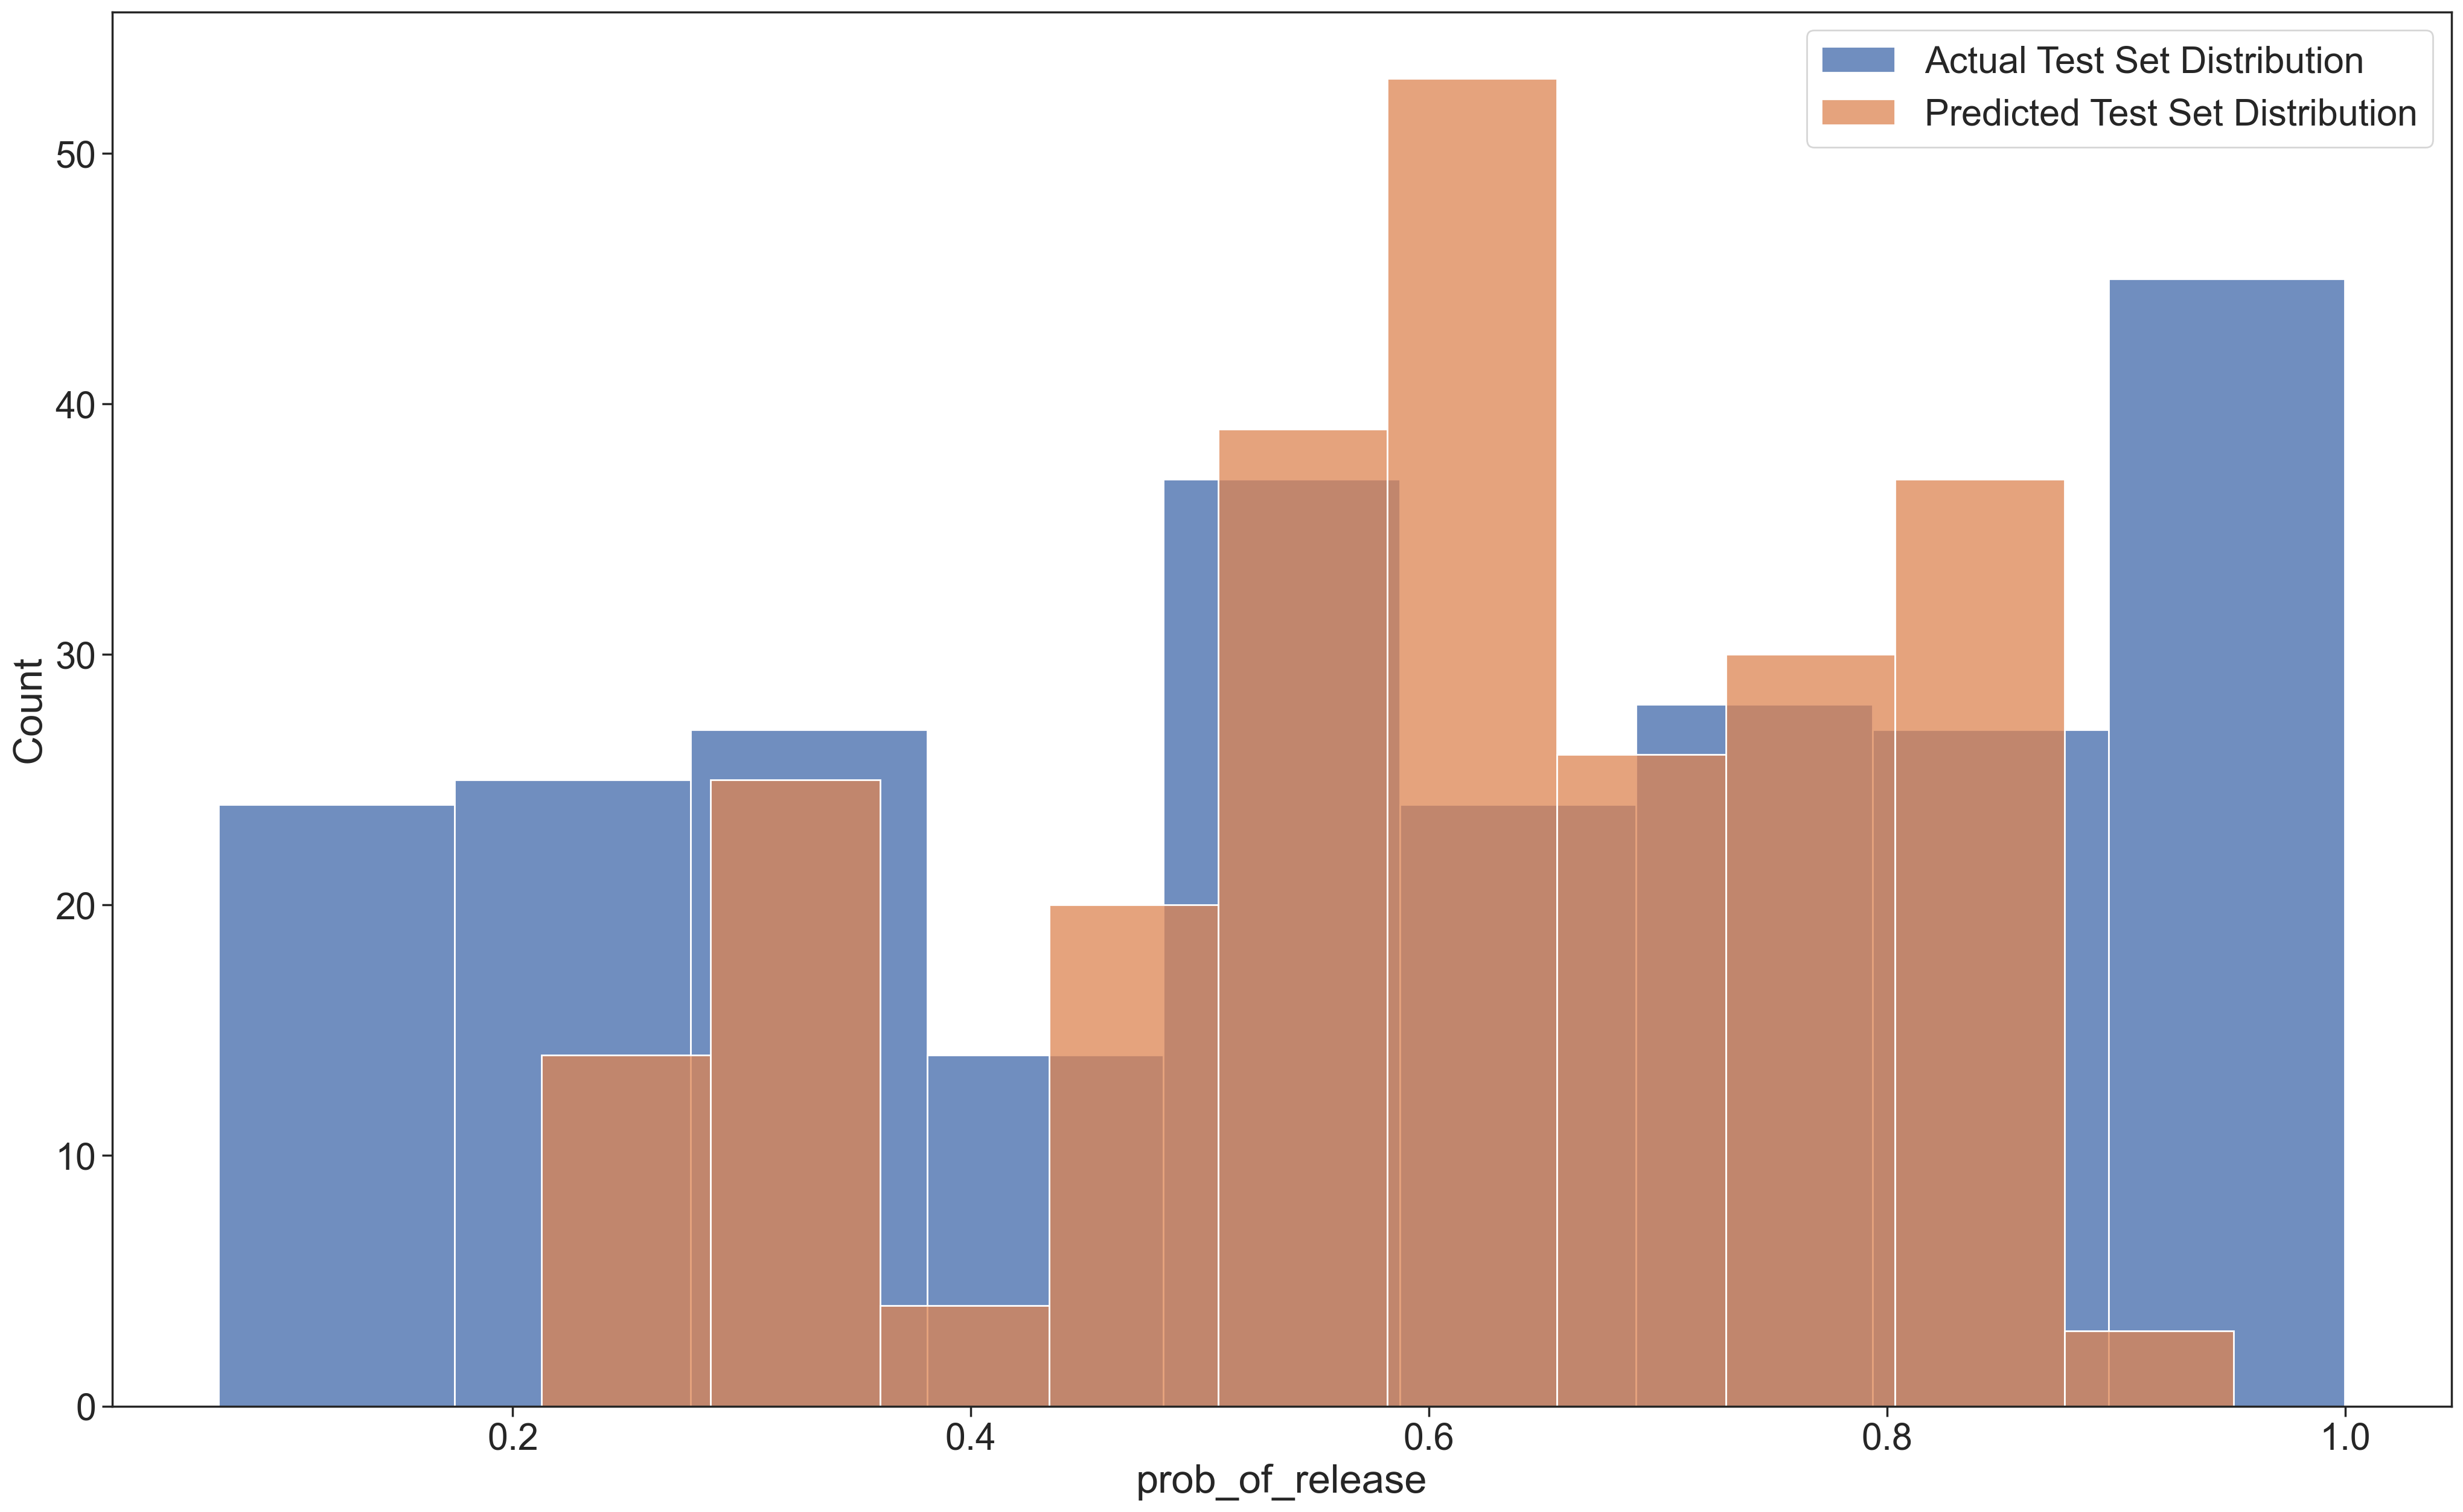

In [16]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=test_df["predicted_prob"], ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


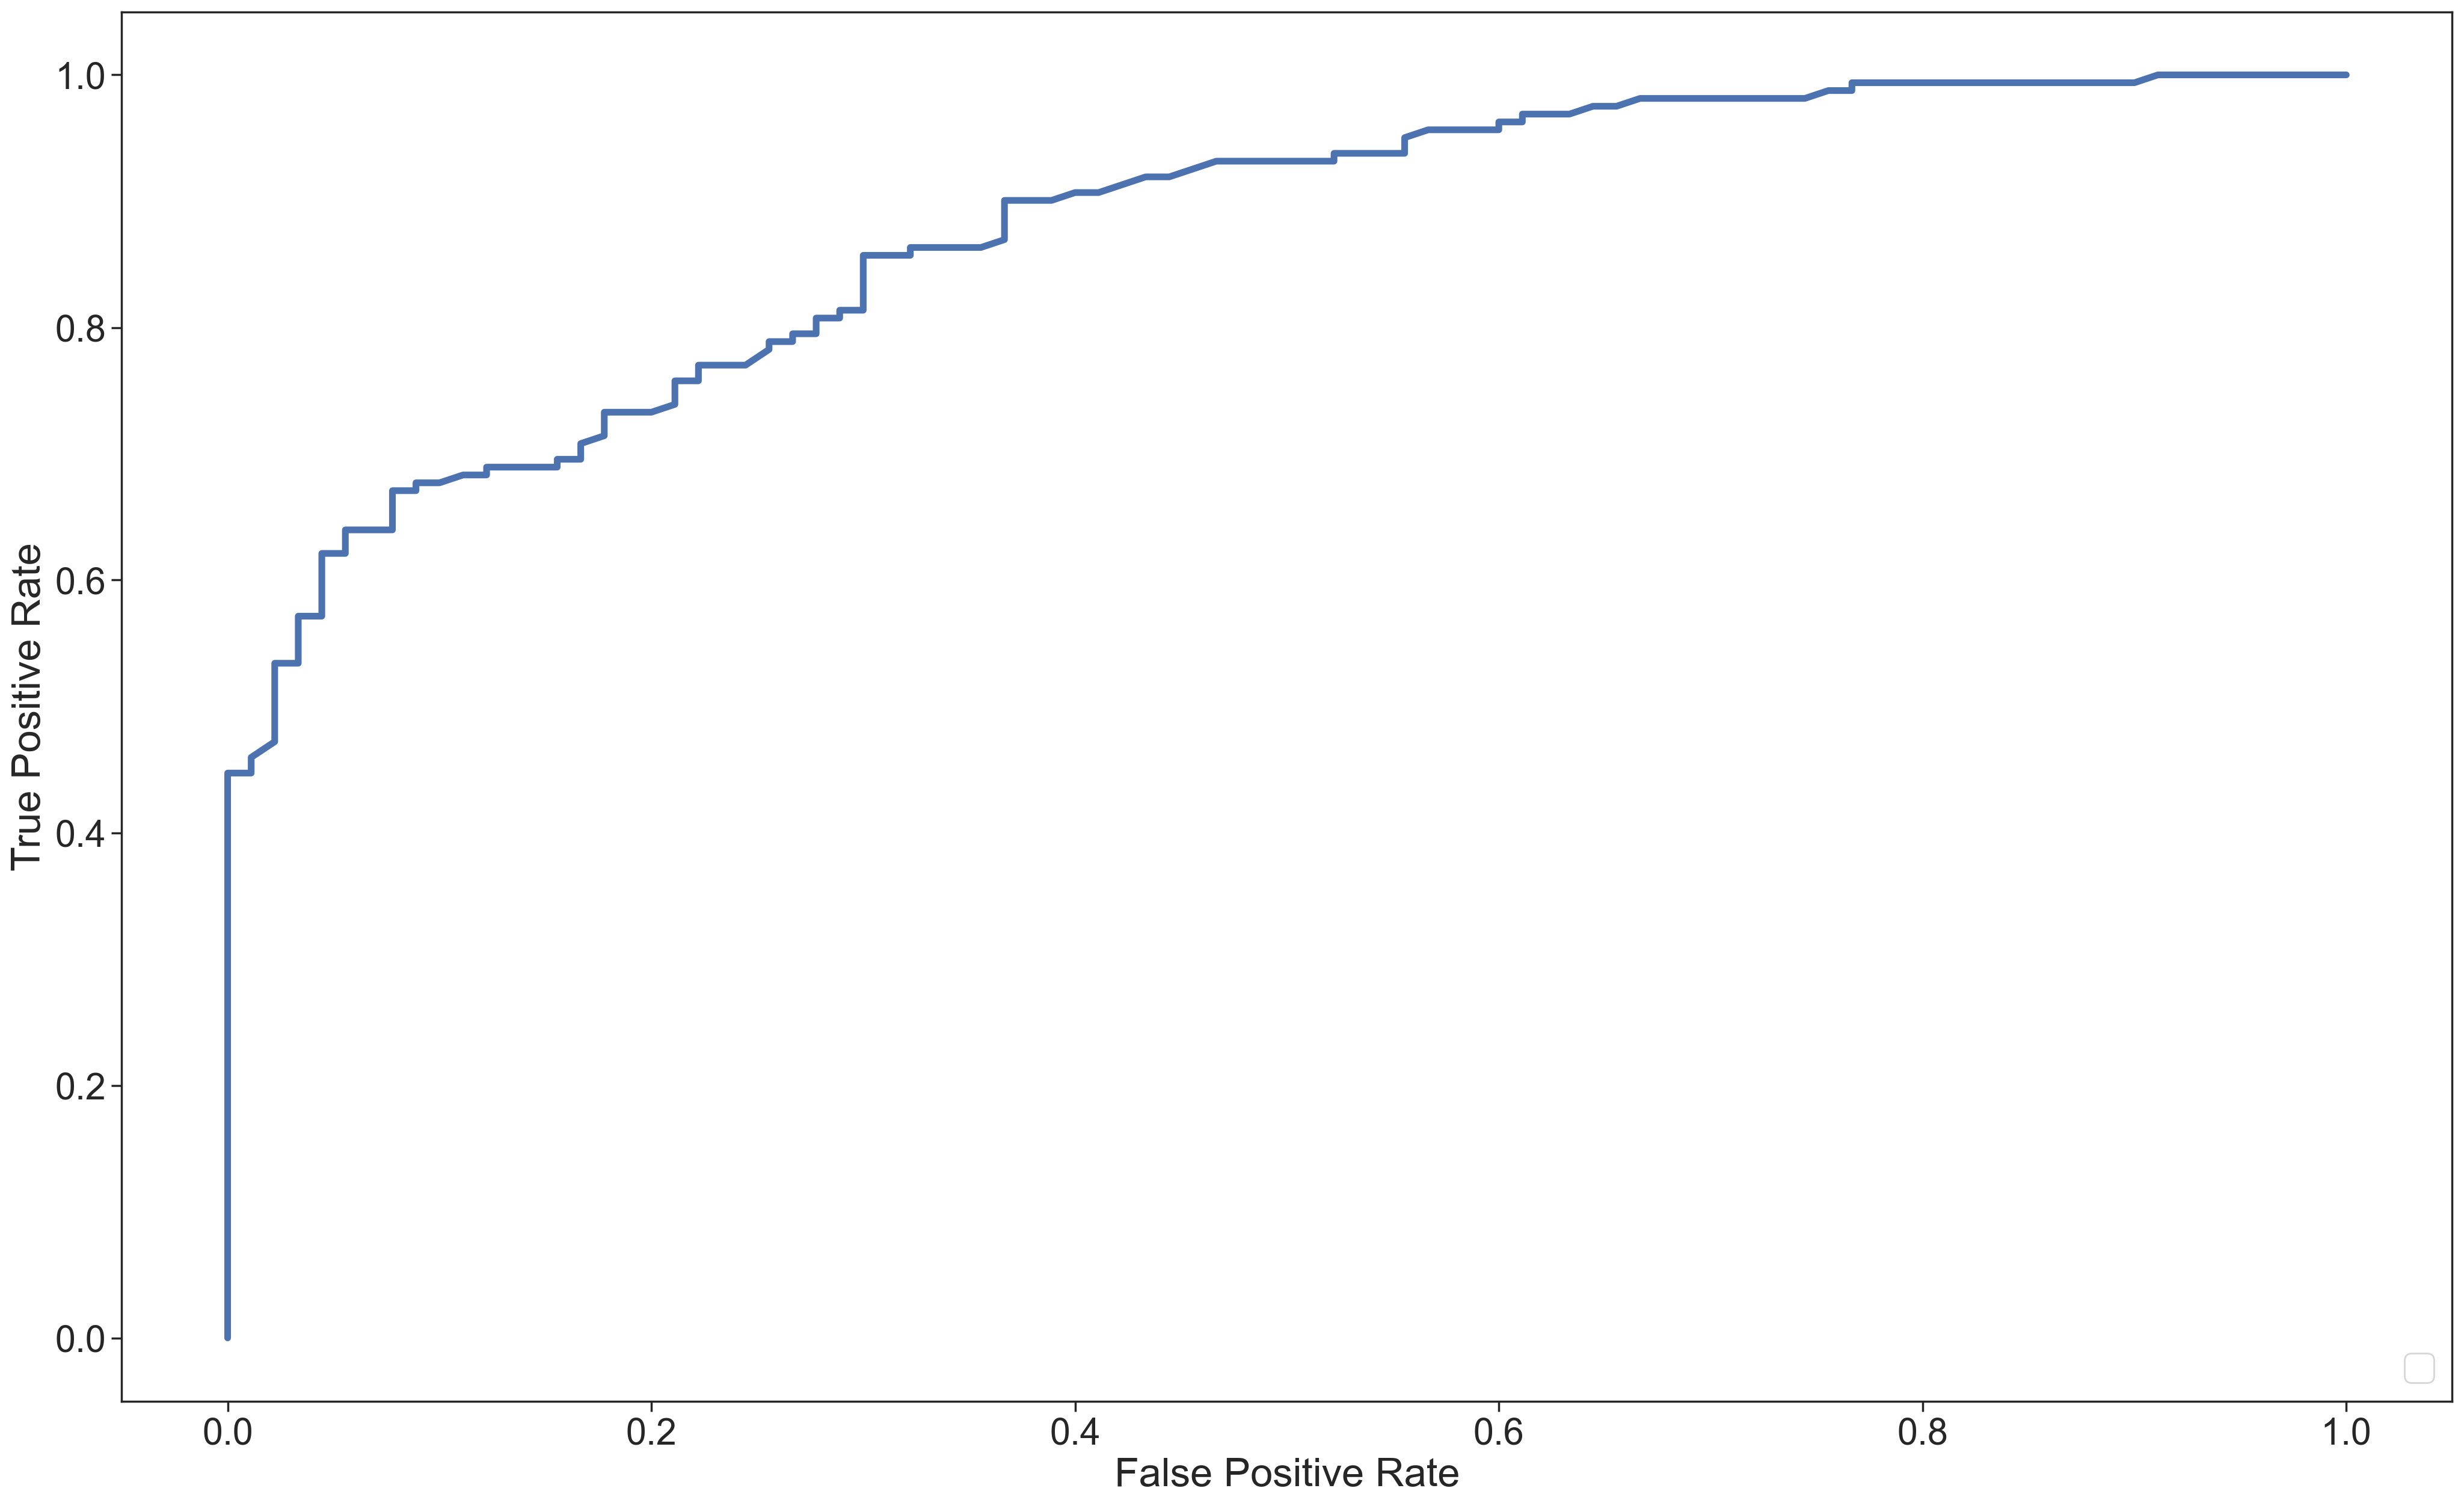

In [17]:
fp_rate, tp_rate, thresholds = roc_curve(test_df["binary_target"], test_df["predicted_prob"], pos_label=1)
RocCurveDisplay(fpr=fp_rate, tpr=tp_rate).plot(linewidth=4)
# sns.lineplot(x=thresholds, y=tp_rate)

## Predictions for the Next Month

In [18]:
model = train_model(df)

In [21]:
# based on https://machinelearningmastery.com/prediction-intervals-for-machine-learning/

sum_errs = np.sum((df["prob_of_release"] - model.predict(df[features])) ** 2)
stdev = np.sqrt(1 / (len(df["prob_of_release"]) - 2) * sum_errs)
stdev

0.2007547436439056

In [22]:
next_month["predicted_prob"] = model.predict(next_month[features])

In [23]:
next_month["predicted_min"] = next_month["predicted_prob"] - (1.96 * stdev)
next_month["predicted_min"] = next_month["predicted_min"].apply(lambda x : 0 if x < 0 else x)
next_month["predicted_max"] = next_month["predicted_prob"] + (1.96 * stdev)
next_month["predicted_max"] = next_month["predicted_max"].apply(lambda x : 1 if x > 1 else x)

In [24]:
next_month[["index", "predicted_min", "predicted_prob", "predicted_max"]]

,index,predicted_min,predicted_prob,predicted_max
1,2023-12-31,0.000000,0.220795,0.614275
2,2024-01-01,0.079881,0.473360,0.866839
3,2024-01-02,0.197337,0.590816,0.984295
4,2024-01-03,0.313221,0.706700,1.000000
5,2024-01-04,0.370034,0.763513,1.000000
6,2024-01-05,0.401109,0.794588,1.000000
7,2024-01-06,0.389187,0.782666,1.000000
8,2024-01-07,0.384144,0.777624,1.000000
9,2024-01-08,0.408790,0.802269,1.000000
10,2024-01-09,0.473503,0.866983,1.000000


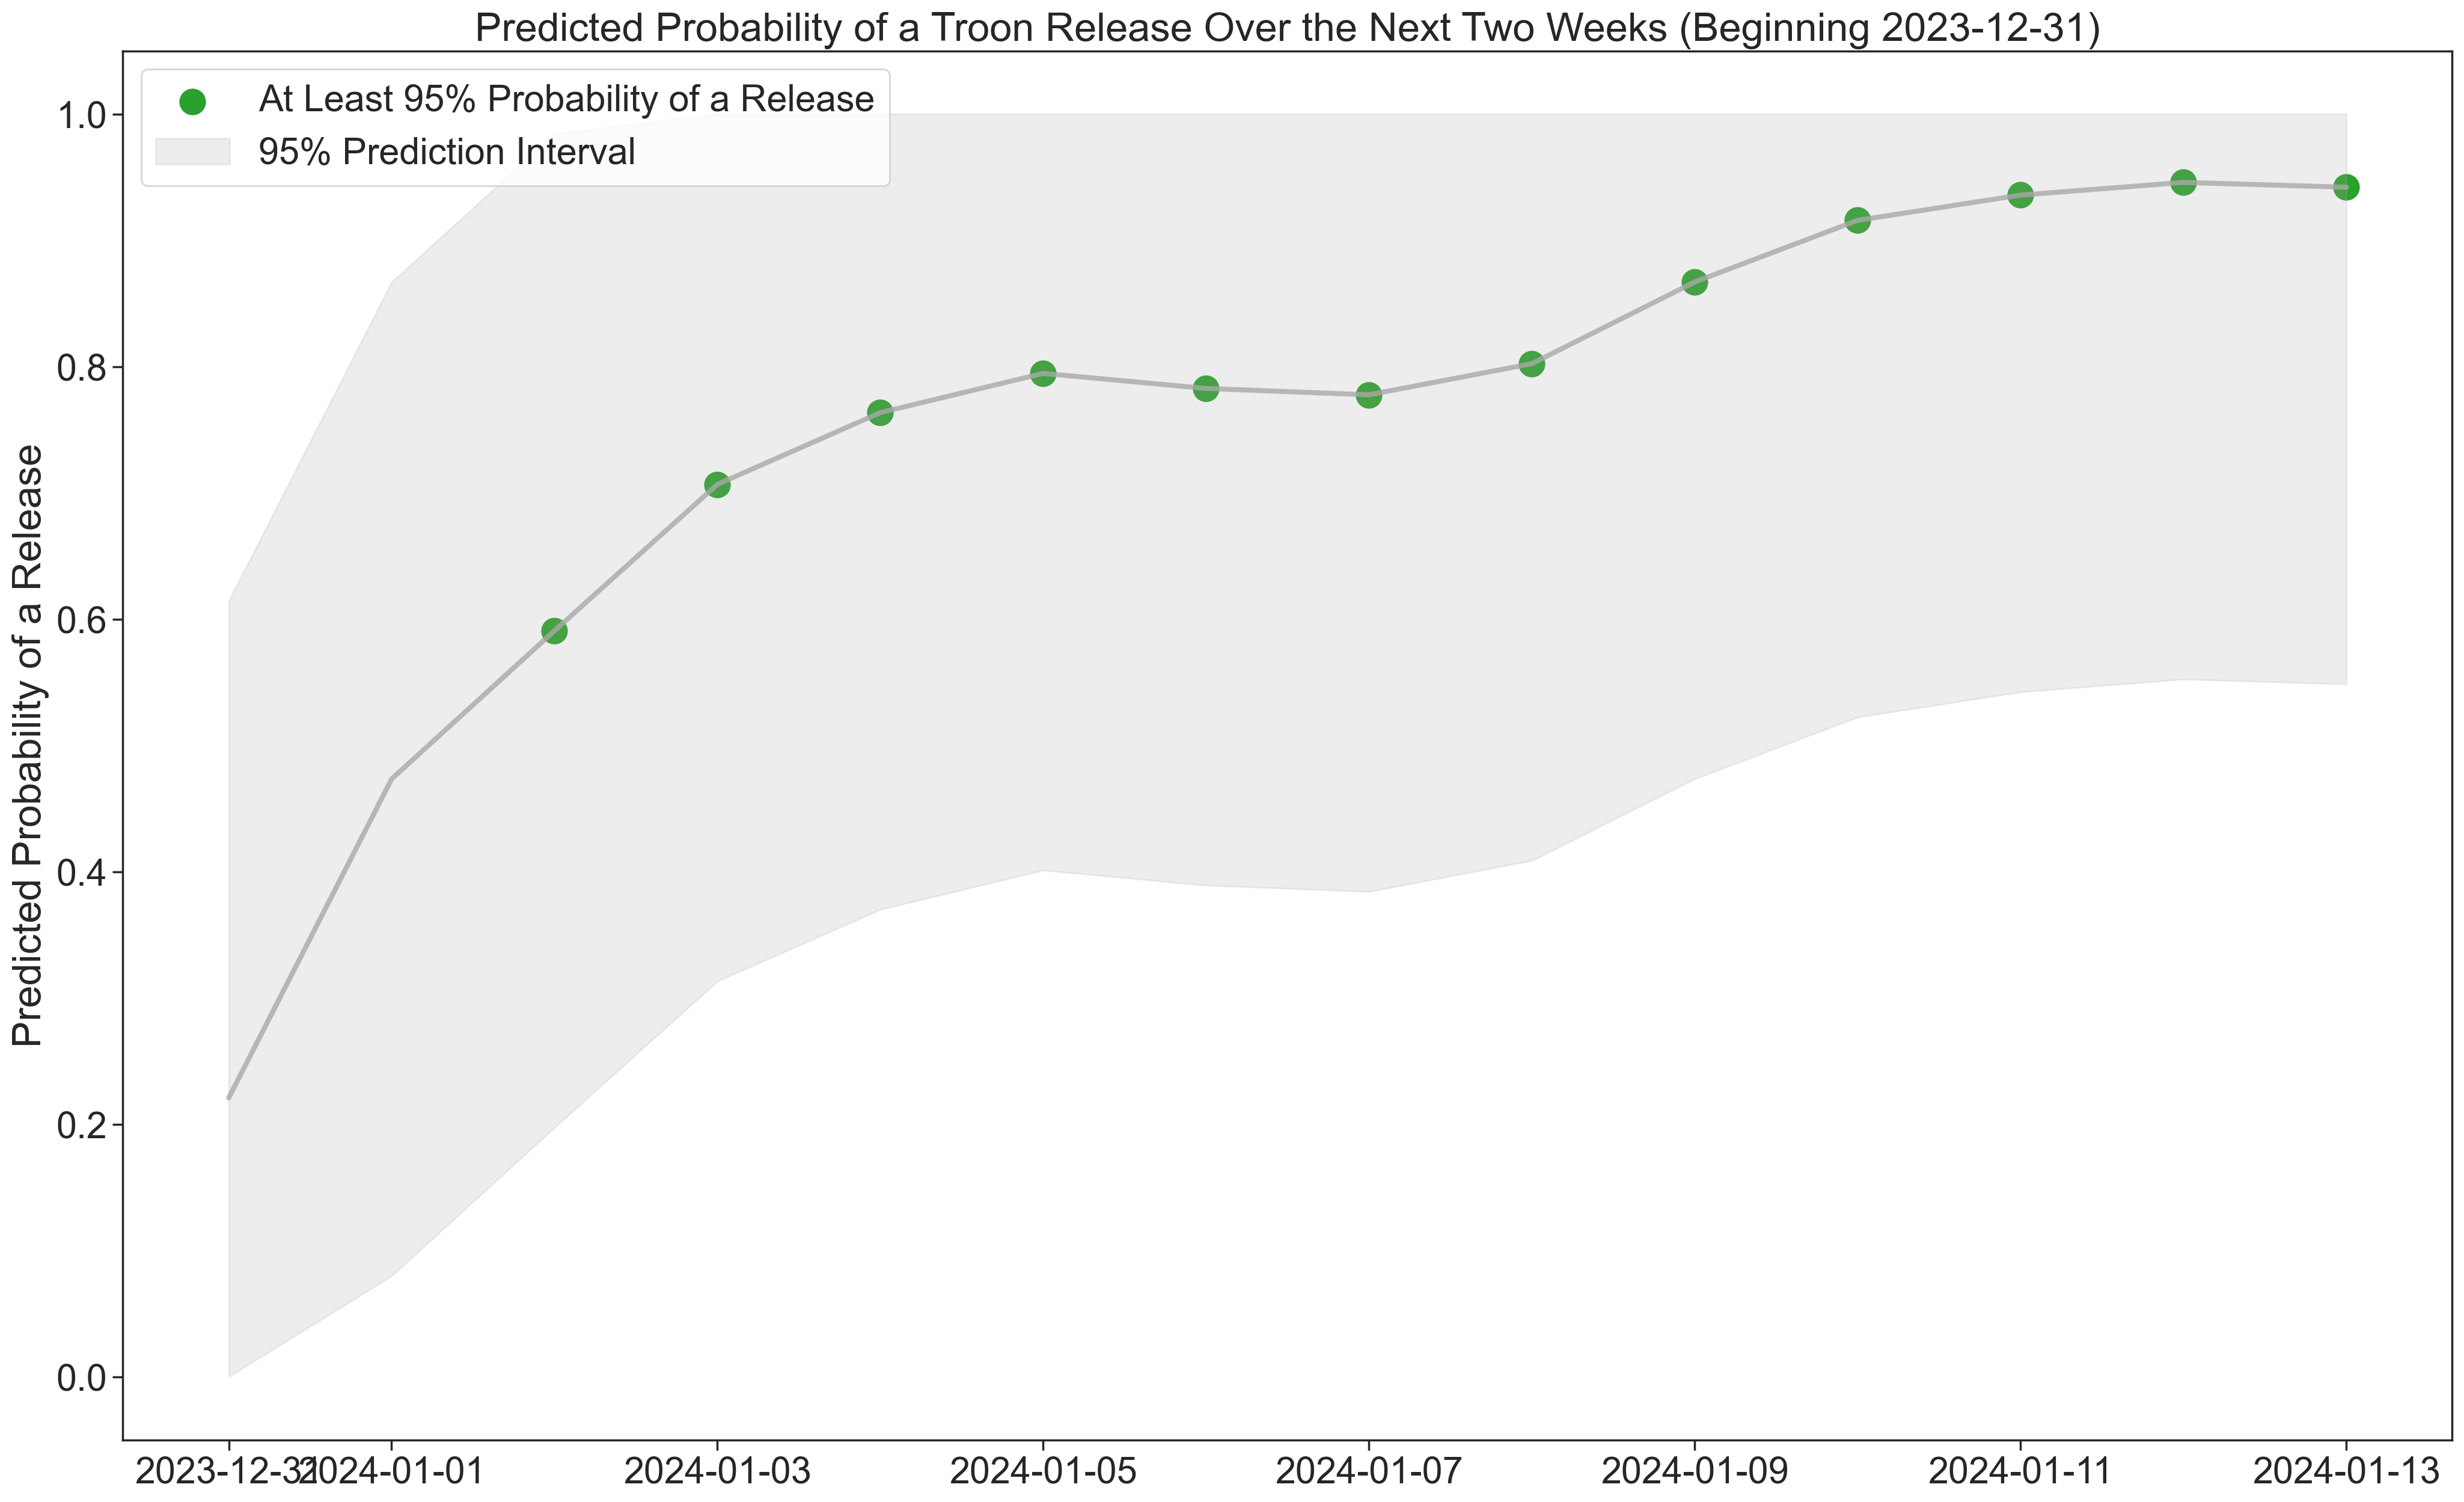

In [25]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 95% Probability of a Release")

ax.fill_between(x=next_month[:14]["index"],
                y1=next_month[:14]["predicted_min"],
                y2=next_month[:14]["predicted_max"],
                label="95% Prediction Interval",
                alpha=0.2,
                color="darkgrey")

ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
ax.legend()
plt.show()